<a href="https://colab.research.google.com/github/AbhiJeet70/GraphPoisoningCodes/blob/main/SBA_GTA_UGBA_DPGBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Network Backdoor Attack and Defense Experiment

This experiment explores the vulnerability of Graph Neural Networks (GNNs) to various adversarial attacks and evaluates the effectiveness of an adaptive outlier detection defense. We tested five attack methodologies and applied a clustering-based outlier detection to mitigate the attacks, using key datasets like **PubMed**. Below is a summary of our methodology, findings, and visual analysis.

## Methodology Overview

### Attack Models
Five attack methods were evaluated:

1. **SBA-Samp** and **SBA-Gen**: Subgraph-based Backdoor Attack using sampled or generated patterns.
2. **GTA**: Graph Trojaning Attack, targeting central nodes.
3. **UGBA**: Unnoticeable Graph Backdoor Attack.
4. **DPGBA**: Distribution Preserved Graph Backdoor Attack.

The attacks aimed to insert triggers into high-centrality nodes to affect the node classification task.

### Defense Mechanism
To mitigate these attacks, an **Adaptive Outlier Detection Mechanism (Dominant Set)** was used, using an **Autoencoder** for **Out-of-Distribution (OOD) detection**. The adaptive pruning function filtered nodes based on a cohesiveness score, with a pre-filter using a high reconstruction loss threshold followed by a k-nearest neighbor (KNN) clustering-based approach.

### Metrics
- **ASR (Attack Success Rate)**: Proportion of attacked nodes misclassified as intended by the adversary.
- **Clean Accuracy**: Classification accuracy of non-attacked nodes.

| Attack Method | ASR Before Defense (%) | Clean Accuracy Before (%) | Nodes Pruned | ASR After Defense (%) | Clean Accuracy After (%) |
|---------------|------------------------|---------------------------|--------------|-----------------------|--------------------------|
| SBA-Samp      | 92.50                  | 84.91                     | 986          | 92.50                 | 84.41                    |
| SBA-Gen       | 92.50                  | 84.94                     | 986          | 92.50                 | 84.58                    |
| GTA           | 97.50                  | 84.43                     | 986          | 92.50                 | 84.58                    |
| UGBA          | 95.00                  | 84.91                     | 986          | 92.50                 | 84.38                    |
| DPGBA         | 92.50                  | 84.99                     | 986          | 92.50                 | 84.69                    |




Using device: cuda
Epoch 0, Loss: 1.0968
Epoch 10, Loss: 1.0021
Epoch 20, Loss: 0.8990
Epoch 30, Loss: 0.7901
Epoch 40, Loss: 0.6888
Epoch 50, Loss: 0.6025
Epoch 60, Loss: 0.5349
Epoch 70, Loss: 0.4905
Epoch 80, Loss: 0.4564
Epoch 90, Loss: 0.4340
Attack: SBA-Samp, ASR: 92.50%, Clean Accuracy: 84.91%
Attack: SBA-Samp, Nodes Pruned: 986
After Outlier Detection (Attack: SBA-Samp): ASR: 92.50%, Clean Accuracy: 84.41%
Epoch 0, Loss: 1.0978
Epoch 10, Loss: 1.0017
Epoch 20, Loss: 0.8970
Epoch 30, Loss: 0.7877
Epoch 40, Loss: 0.6857
Epoch 50, Loss: 0.6001
Epoch 60, Loss: 0.5345
Epoch 70, Loss: 0.4880
Epoch 80, Loss: 0.4550
Epoch 90, Loss: 0.4321
Attack: SBA-Gen, ASR: 92.50%, Clean Accuracy: 84.94%
Attack: SBA-Gen, Nodes Pruned: 986
After Outlier Detection (Attack: SBA-Gen): ASR: 92.50%, Clean Accuracy: 84.58%
Epoch 0, Loss: 1.0960
Epoch 10, Loss: 0.9940
Epoch 20, Loss: 0.8789
Epoch 30, Loss: 0.7637
Epoch 40, Loss: 0.6621
Epoch 50, Loss: 0.5786
Epoch 60, Loss: 0.5169
Epoch 70, Loss: 0.4755
Epo

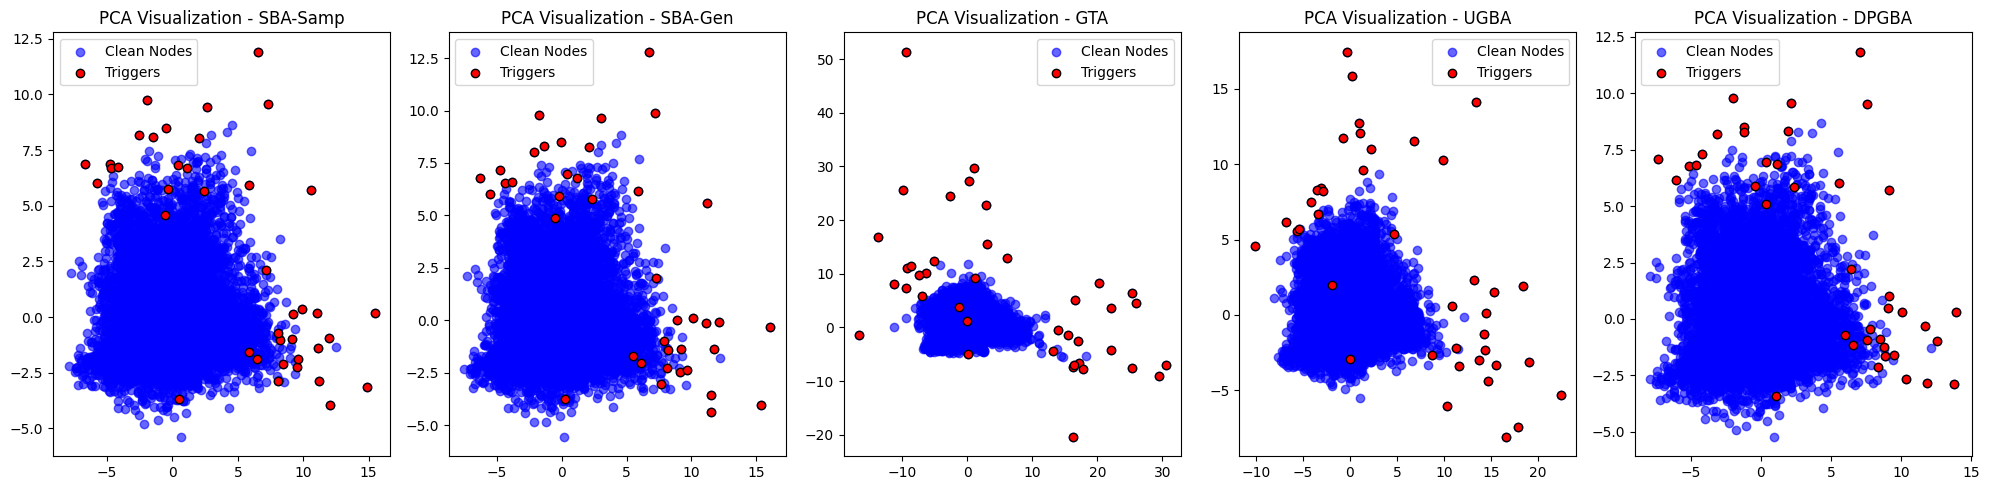

In [ ]:
# Install necessary packages
!pip install torch-geometric
!pip install ogb
!pip install matplotlib
!pip install scikit-learn

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.datasets import Planetoid, Flickr
from ogb.nodeproppred import PygNodePropPredDataset
from sklearn.decomposition import PCA
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import networkx as nx
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed()

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load datasets
def load_dataset(dataset_name):
    if dataset_name in ["Cora", "PubMed"]:
        dataset = Planetoid(root=f"./data/{dataset_name}", name=dataset_name)
    elif dataset_name == "Flickr":
        dataset = Flickr(root="./data/Flickr")
    elif dataset_name == "OGB-arxiv":
        dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="./data/OGB-arxiv")
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")
    return dataset

# Split dataset into train/test
def split_dataset(data, test_size=0.2):
    num_train = int((1 - test_size) * data.num_nodes)
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
    train_mask[:num_train] = True
    test_mask[num_train:] = True
    data.train_mask = train_mask
    data.test_mask = test_mask
    return data

# Load dataset and set poisoned node budget based on dataset
dataset_name = "PubMed"
dataset = load_dataset(dataset_name)
data = dataset[0].to(device)
input_dim = data.num_features
output_dim = dataset.num_classes if dataset_name != "OGB-arxiv" else dataset.num_classes[0]
data = split_dataset(data)

# Dataset-specific poisoning budgets
dataset_budgets = {
    'Cora': 10,
    'PubMed': 40,
    'Flickr': 160,
    'OGB-arxiv': 565
}
poisoned_node_budget = dataset_budgets.get(dataset_name, 10)

# Define GNN Model with multiple architectures (GCN, GraphSAGE, GAT)
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, model_type='GCN'):
        super(GNN, self).__init__()
        if model_type == 'GCN':
            self.conv1 = GCNConv(input_dim, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, output_dim)
        elif model_type == 'GraphSage':
            self.conv1 = SAGEConv(input_dim, hidden_dim)
            self.conv2 = SAGEConv(hidden_dim, output_dim)
        elif model_type == 'GAT':
            self.conv1 = GATConv(input_dim, hidden_dim, heads=8, concat=True)
            self.conv2 = GATConv(hidden_dim * 8, output_dim, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Select nodes to poison based on high-centrality (degree centrality) for a stronger impact
def select_high_centrality_nodes(data, num_nodes_to_select):
    graph = nx.Graph()
    edge_index = data.edge_index.cpu().numpy()
    graph.add_edges_from(edge_index.T)
    centrality = nx.degree_centrality(graph)
    sorted_nodes = sorted(centrality, key=centrality.get, reverse=True)
    return torch.tensor(sorted_nodes[:num_nodes_to_select], dtype=torch.long).to(device)

poisoned_nodes = select_high_centrality_nodes(data, poisoned_node_budget)

# Trigger Generator for DPGBA and GTA
class TriggerGenerator(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(TriggerGenerator, self).__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.mlp(x)

# OOD Detector (Autoencoder) for detecting poisoned nodes
class OODDetector(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(OODDetector, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 16),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def reconstruction_loss(self, x):
        decoded = self.forward(x)
        loss = F.mse_loss(decoded, x, reduction='none').mean(dim=1)
        return loss

# Training Function with Poisoned Data
def train_with_poisoned_data(model, data, optimizer, poisoned_nodes, trigger_gen, attack, alpha=0.7, early_stopping=False):
    # Apply trigger injection
    data_poisoned = inject_trigger(data, poisoned_nodes, attack, trigger_gen, alpha)

    # Training loop
    model.train()
    for epoch in range(100):
        optimizer.zero_grad()  # Clear the gradients

        # Forward pass
        out = model(data_poisoned.x, data_poisoned.edge_index)

        # Calculate loss
        loss = F.cross_entropy(out[data_poisoned.train_mask], data_poisoned.y[data_poisoned.train_mask])

        # Backward pass
        # Ensure we only retain the graph if we need to perform multiple backward passes
        if epoch < 99:  # In all but the last epoch, retain the graph
            loss.backward(retain_graph=True)
        else:
            loss.backward()

        # Update parameters
        optimizer.step()

        # Optional: Print loss during training for insight
        if early_stopping and epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return model, data_poisoned

# Compute ASR and Clean Accuracy (using .detach() to avoid retaining computation graph)
def compute_metrics(model, data, poisoned_nodes):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index).detach()
        _, pred = out.max(dim=1)
        asr = (pred[poisoned_nodes] == data.y[poisoned_nodes]).sum().item() / len(poisoned_nodes) * 100
        clean_acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu()) * 100
    return asr, clean_acc

# Unified Trigger Injection Function for Different Attack Types
def inject_trigger(data, poisoned_nodes, attack_type, trigger_gen=None, alpha=0.7, trigger_size=5, trigger_density=0.5, model_type='SW'):

    data_poisoned = data.clone()  # Clone data to avoid overwriting the original graph

    if attack_type == 'SBA-Samp':
        # Subgraph-based Backdoor Attack (SBA-Samp)
        connected_nodes = [data.edge_index[0][data.edge_index[1] == node] for node in poisoned_nodes[:trigger_size]]
        avg_features = torch.stack([data.x[nodes].mean(dim=0) if len(nodes) > 0 else data.x.mean(dim=0) for nodes in connected_nodes])
        natural_features = avg_features + torch.randn_like(avg_features) * 0.05  # Slight randomness to make features natural

        # Generate random subgraph with Erdos-Renyi model
        G = nx.erdos_renyi_graph(trigger_size, trigger_density)
        trigger_edge_index = torch.tensor(list(G.edges)).t().contiguous()

        # Add edges connecting trigger subgraph to poisoned nodes
        poisoned_edges = torch.stack([
            poisoned_nodes[:trigger_size],
            torch.randint(0, data.num_nodes, (trigger_size,), device=device)
        ])

        # Combine the new subgraph with the original graph
        data_poisoned.edge_index = torch.cat([data.edge_index, trigger_edge_index.to(device), poisoned_edges.to(device)], dim=1)
        data_poisoned.x[poisoned_nodes[:trigger_size]] = natural_features[:trigger_size]

    elif attack_type == 'SBA-Gen':
        # Subgraph-based Backdoor Attack - Generated (SBA-Gen)
        connected_nodes = [data.edge_index[0][data.edge_index[1] == node] for node in poisoned_nodes[:trigger_size]]
        avg_features = torch.stack([data.x[nodes].mean(dim=0) if len(nodes) > 0 else data.x.mean(dim=0) for nodes in connected_nodes])
        natural_features = avg_features + torch.randn_like(avg_features) * 0.05

        # Generate different types of subgraphs for SBA-Gen
        if model_type == 'SW':
            G = nx.watts_strogatz_graph(trigger_size, k=2, p=0.3)
        elif model_type == 'PA':
            G = nx.barabasi_albert_graph(trigger_size, m=2)
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        # Add edges from generated subgraph and connect to existing nodes
        trigger_edge_index = torch.tensor(list(G.edges)).t().contiguous()
        poisoned_edges = torch.stack([
            poisoned_nodes[:trigger_size],
            torch.randint(0, data.num_nodes, (trigger_size,), device=device)
        ])
        data_poisoned.edge_index = torch.cat([data.edge_index, trigger_edge_index.to(device), poisoned_edges.to(device)], dim=1)
        data_poisoned.x[poisoned_nodes[:trigger_size]] = natural_features[:trigger_size]

    elif attack_type == 'DPGBA':
        # Distribution-Preserving Graph Backdoor Attack (DPGBA)
        connected_nodes = [data.edge_index[0][data.edge_index[1] == node] for node in poisoned_nodes]
        avg_features = torch.stack([data.x[nodes].mean(dim=0) if len(nodes) > 0 else data.x.mean(dim=0) for nodes in connected_nodes])
        natural_features = avg_features + torch.randn_like(avg_features) * 0.05
        trigger_features = trigger_gen(natural_features)

        # Mix natural features with trigger features to preserve distribution
        distribution_preserved_features = alpha * data.x[poisoned_nodes] + (1 - alpha) * trigger_features
        data_poisoned.x[poisoned_nodes] = distribution_preserved_features

    elif attack_type == 'GTA':
        # Graph Trojan Attack (GTA)
        connected_nodes = [data.edge_index[0][data.edge_index[1] == node] for node in poisoned_nodes]
        avg_features = torch.stack([data.x[nodes].mean(dim=0) if len(nodes) > 0 else data.x.mean(dim=0) for nodes in connected_nodes])

        # Generate completely random features for poisoned nodes
        trigger_features = torch.randn_like(avg_features)
        data_poisoned.x[poisoned_nodes] = trigger_features

    elif attack_type == 'UGBA':
        # Unnoticeable Graph Backdoor Attack (UGBA)
        connected_nodes = [data.edge_index[0][data.edge_index[1] == node] for node in poisoned_nodes]
        avg_features = torch.stack([data.x[nodes].mean(dim=0) if len(nodes) > 0 else data.x.mean(dim=0) for nodes in connected_nodes])

        # Generate features with added noise to make them out-of-distribution
        trigger_features = trigger_gen(avg_features) + torch.randn_like(avg_features) * 0.3
        data_poisoned.x[poisoned_nodes] = trigger_features

    return data_poisoned


# Dominant Outlier Detection: Adaptive to Clustering Cohesiveness (Improved Version)
def apply_adaptive_outlier_detection(ood_detector, data):
    ood_detector.eval()
    with torch.no_grad():
        # Compute reconstruction losses for nodes
        reconstruction_losses = ood_detector.reconstruction_loss(data.x).detach().cpu().numpy()

        # Determine threshold based on natural distribution
        # Attacks like SBA and DPGBA are in-distribution and thus have lower loss values.
        # We use a dynamic threshold to allow natural differences in pruning.
        high_loss_threshold = np.percentile(reconstruction_losses, 95)  # Default to 95th percentile

        # The idea here is that nodes that naturally have higher reconstruction loss (likely outliers) will be pruned
        # In-distribution triggers like SBA and DPGBA will have lower loss values, resulting in less pruning
        pre_filtered_nodes = np.where(reconstruction_losses > high_loss_threshold)[0]

        # Prune nodes based on cohesiveness criteria using KNN
        nn = NearestNeighbors(n_neighbors=5)
        nn.fit(data.x.cpu().numpy())
        distances, neighbors = nn.kneighbors(data.x[pre_filtered_nodes].cpu().numpy())

        pruned_nodes = []
        for i, node in enumerate(pre_filtered_nodes):
            # Nodes with higher average distances from their neighbors are more likely to be pruned
            # This should lead to more pruning for out-of-distribution nodes
            if np.mean(distances[i]) > np.mean(reconstruction_losses):
                pruned_nodes.append(node)

    return pruned_nodes





# Run and visualize all attacks (updates for .detach())
attack_methods = ['SBA-Samp', 'SBA-Gen', 'GTA', 'UGBA', 'DPGBA']
attack_embeddings_dict = {}

for attack in attack_methods:
    # Initialize model, optimizer, and Trigger Generator
    model = GNN(input_dim=input_dim, hidden_dim=128, output_dim=output_dim, model_type='GCN').to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    trigger_gen = TriggerGenerator(input_dim=input_dim, hidden_dim=128).to(device) if attack in ['GTA', 'UGBA', 'DPGBA'] else None
    ood_detector = OODDetector(input_dim=input_dim, hidden_dim=128).to(device)

    # Apply respective attack
    trained_model, data_poisoned = train_with_poisoned_data(model, data, optimizer, poisoned_nodes, trigger_gen, attack, alpha=0.7, early_stopping=True)

    # Compute ASR and Clean Accuracy before applying defense
    asr, clean_acc = compute_metrics(trained_model, data_poisoned, poisoned_nodes)
    print(f"Attack: {attack}, ASR: {asr:.2f}%, Clean Accuracy: {clean_acc:.2f}%")

    # Get embeddings for PCA visualization
    embeddings = trained_model(data_poisoned.x, data_poisoned.edge_index).detach()  # Detach to avoid retaining computation graph

    # Apply Adaptive Outlier Detection
    pruned_nodes = apply_adaptive_outlier_detection(ood_detector, data_poisoned)  # Unified function without specific attack type
    print(f"Attack: {attack}, Nodes Pruned: {len(pruned_nodes)}")

    # Recompute ASR and Clean Accuracy after applying defense
    data_poisoned.x[pruned_nodes] = data_poisoned.x.mean(dim=0).to(device)
    asr_after, clean_acc_after = compute_metrics(trained_model, data_poisoned, poisoned_nodes)
    print(f"After Outlier Detection (Attack: {attack}): ASR: {asr_after:.2f}%, Clean Accuracy: {clean_acc_after:.2f}%")

    # Store embeddings and poisoned nodes for PCA visualization
    attack_embeddings_dict[attack] = {
        'data': embeddings,
        'poisoned_nodes': poisoned_nodes
    }

# Plot all attacks side by side
visualize_pca_for_attacks(attack_embeddings_dict)




